# 1. Load the processed data

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 1. Load data from Step 4
df = pd.read_csv('data/processed/processed_data.csv')
df.head(5)

,telecommuting,has_company_logo,has_questions,word_count,unique_word_count,lexical_diversity,flesch_score,dale_chall_score,has_company_info,has_benefits,salary_explicit,log_company_credibility,location_clean_enc,required_experience_clean_enc,employment_type_clean_enc,industry_clean_enc,function_clean_enc,fraudulent
0,0,1,0,163.0,139.0,0.852761,-22.565968,15.116055,1,0,1,3.737670,2150,5,0,83,23,0
1,0,1,0,334.0,221.0,0.661677,41.551532,11.790945,1,1,1,3.218876,931,0,2,75,8,0
2,0,1,0,157.0,111.0,0.707006,13.950333,11.094967,1,0,1,5.141664,1592,7,3,83,24,0
3,0,1,0,352.0,257.0,0.730114,-15.455136,13.556080,1,1,1,3.871201,1437,6,2,22,32,0
4,0,1,1,197.0,159.0,0.807107,-54.455000,16.282850,1,1,1,4.110874,1477,6,2,50,17,0


In [ ]:
df.shape

(17880, 18)

# 2. Train–Test Split

In [ ]:
print(X.shape, y.value_counts(normalize=True))
X = df.drop('fraudulent', axis=1)
y = df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42,stratify=y)

(17880, 17) fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: float64


# 3.Handle Class Imbalance (SMOTE – Train Only)

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


print('Before SMOTE:', y_train.value_counts())
print('After SMOTE:', y_train_res.value_counts())

Before SMOTE: fraudulent
0    13611
1      693
Name: count, dtype: int64
After SMOTE: fraudulent
0    13611
1    13611
Name: count, dtype: int64


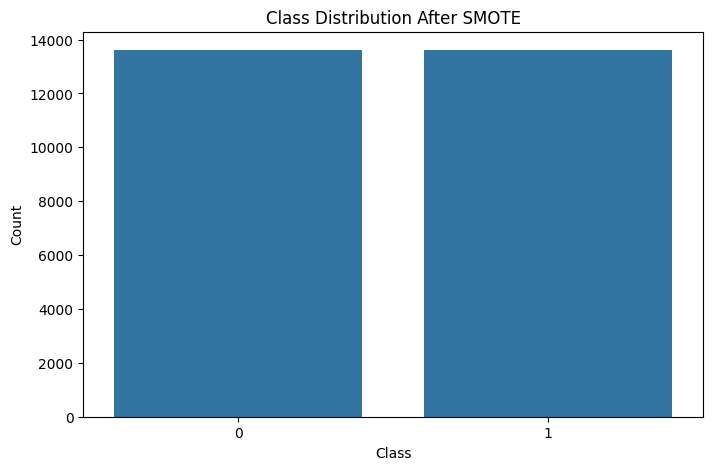

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a count plot
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train_res)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# 4. Scaling (ONLY for linear / distance models)

In [ ]:
scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# 5. Visual Diagnostics: PCA Comparisons

# 5.1 Before SMOTE (Scaled)

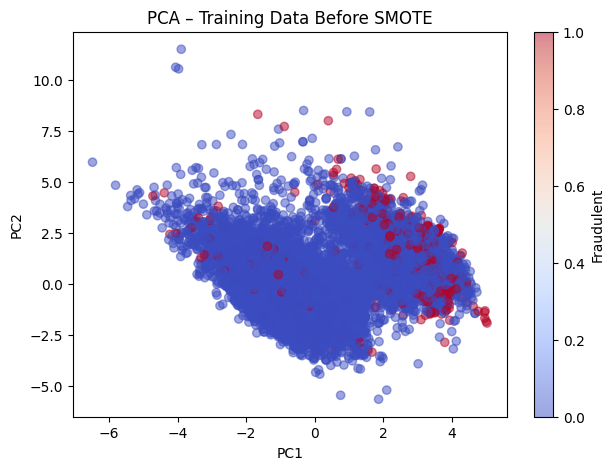

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(StandardScaler().fit_transform(X_train))


y_train_np = y_train.to_numpy()


plt.figure(figsize=(7,5))
sc = plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train_np, cmap='coolwarm', alpha=0.5)
plt.colorbar(sc, label='Fraudulent')
plt.title('PCA – Training Data Before SMOTE')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()



# 5.2 After SMOTE (Scaled)

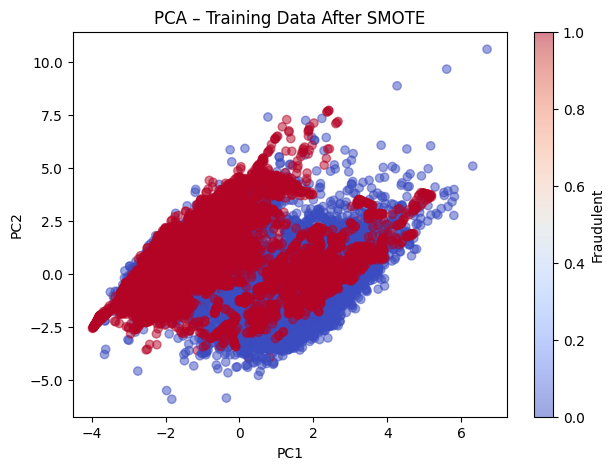

In [ ]:
X_train_res_pca = pca.fit_transform(X_train_scaled)
y_train_res_np = y_train_res.to_numpy()


plt.figure(figsize=(7,5))
sc = plt.scatter(X_train_res_pca[:,0], X_train_res_pca[:,1], c=y_train_res_np, cmap='coolwarm', alpha=0.5)
plt.colorbar(sc, label='Fraudulent')
plt.title('PCA – Training Data After SMOTE')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()



# 6.Unified Evaluation Function

In [ ]:
def evaluate_model(model, X_test, y_test, name):
  preds = model.predict(X_test)
  probs = model.predict_proba(X_test)[:,1]


  print(f"\n{name}")
  print(classification_report(y_test, preds))
  print('ROC-AUC:', roc_auc_score(y_test, probs))


  cm = confusion_matrix(y_test, preds)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title(f'Confusion Matrix – {name}')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

# 7. Model Training

# 7.1 Logistic Regression (Scaled)


Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      3403
           1       0.18      0.63      0.29       173

    accuracy                           0.85      3576
   macro avg       0.58      0.74      0.60      3576
weighted avg       0.94      0.85      0.88      3576

ROC-AUC: 0.850575571707385


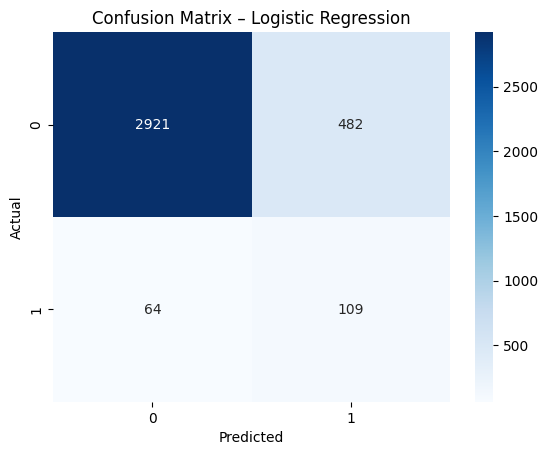

In [ ]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train_res)


evaluate_model(lr, X_test_scaled, y_test, 'Logistic Regression')

# 7.2 SVM (Scaled)


SVM
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      3403
           1       0.36      0.69      0.47       173

    accuracy                           0.93      3576
   macro avg       0.67      0.81      0.72      3576
weighted avg       0.95      0.93      0.94      3576

ROC-AUC: 0.918003325865141


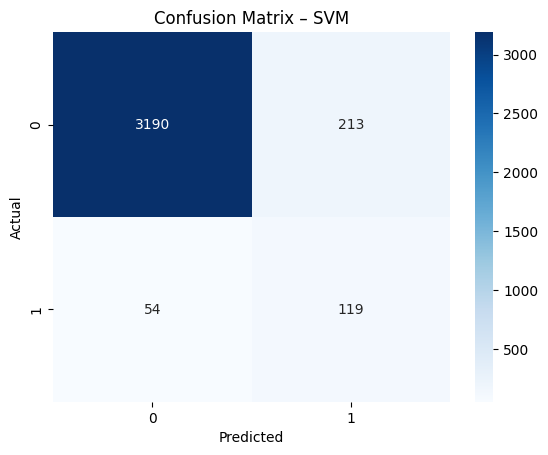

In [ ]:
svm = SVC(kernel='rbf', probability=True, class_weight='balanced')
svm.fit(X_train_scaled, y_train_res)


evaluate_model(svm, X_test_scaled, y_test, 'SVM')

# 7.3. Random Forest (Unscaled)


Random Forest
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3403
           1       0.71      0.73      0.72       173

    accuracy                           0.97      3576
   macro avg       0.85      0.86      0.85      3576
weighted avg       0.97      0.97      0.97      3576

ROC-AUC: 0.9772684421600119


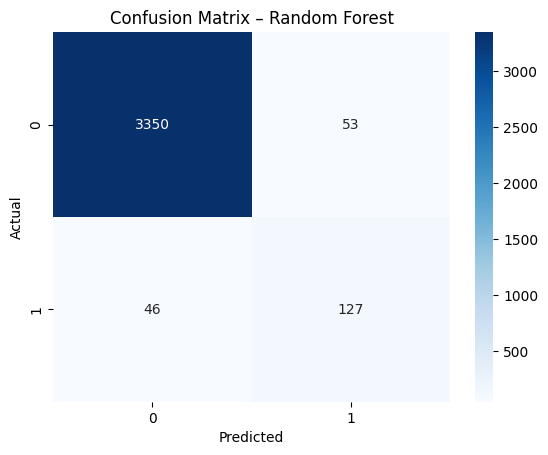

In [ ]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
rf.fit(X_train_res, y_train_res)


evaluate_model(rf, X_test, y_test, 'Random Forest')

# 7.4  XGBoost (Unscaled)


XGBoost
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.74      0.75      0.75       173

    accuracy                           0.98      3576
   macro avg       0.87      0.87      0.87      3576
weighted avg       0.98      0.98      0.98      3576

ROC-AUC: 0.9784175472508956


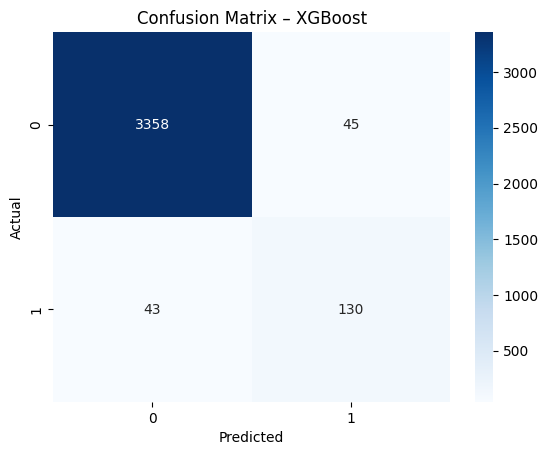

In [ ]:
xgb = XGBClassifier(
n_estimators=300,
max_depth=6,
learning_rate=0.1,
subsample=0.8,
eval_metric='logloss',
random_state=42
)


xgb.fit(X_train_res, y_train_res)


evaluate_model(xgb, X_test, y_test, 'XGBoost')

# 8.Model Persistence

In [ ]:
joblib.dump(xgb, 'models/xgb_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(X.columns.tolist(), 'models/feature_order.pkl')

['/content/drive/MyDrive/Fake_Job_Posting_Detection/models/feature_order.pkl']